# Exercício Prático: Treinando Redes Neurais Profundas (Capítulo 11)

Este notebook complementa o exercício anterior, focando nos desafios de treinar redes neurais profundas (Deep Learning).

**Tópicos abordados:**
1.  O problema do desaparecimento de gradientes.
2.  Estratégias de Inicialização de Pesos (Normal vs He).
3.  Funções de Ativação (Sigmoid vs ReLU).
4.  Batch Normalization.

**Dataset:** utilizaremos o **Fashion MNIST** para esta etapa, pois é um problema de classificação um pouco mais complexo que o Iris, permitindo visualizar melhor os benefícios dessas técnicas em redes mais profundas.

**Para os exercícios de redes neurais, use o container docker abaixo:**

`docker run --rm -p 8888:8888 jupyter/tensorflow-notebook`

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configurar sementes para reprodutibilidade
tf.random.set_seed(42)
np.random.seed(42)

# Carregando o dataset Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalização e Divisão (Treino/Validação)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print("Shape de treino:", X_train.shape)
print("Shape de validação:", X_valid.shape)

2025-12-14 11:13:38.196644: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-14 11:13:39.273379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 11:13:42.029694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape de treino: (55000, 28, 28)
Shape de validação: (5000, 28, 28)


## 1. Inicialização de Pesos e Funções de Ativação

O problema do desaparecimento/explosão de gradientes dificultava o treinamento de redes profundas. Glorot e Bengio demonstraram que a combinação da função de ativação logística (sigmoid) com uma inicialização de pesos inadequada era uma das causas.

### Exercício 1: Modelo Base (Problemático)
Vamos criar uma rede profunda (20 camadas ocultas) usando a configuração "antiga": ativação **Sigmoid** e inicialização **Glorot Uniform** (padrão no Keras para sigmoid, mas vamos deixar explícito).

In [ ]:
from tensorflow import keras
from keras import initializers
import tensorflow as tf

model_sigmoid = keras.models.Sequential()
model_sigmoid.add(keras.layers.Flatten(input_shape=[28, 28]))

# Adicione 20 camadas densas com 100 neurônios cada
# Ativação sigmoid e inicialização normal (média 0, desvio 0.05)
for _ in range(20):
    model_sigmoid.add(
        keras.layers.Dense(
            100,
            activation="sigmoid",
            kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05)
        )
    )

# Camada de saída
model_sigmoid.add(keras.layers.Dense(10, activation="softmax"))

# Compilação
model_sigmoid.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=["accuracy"]
)


/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-12-14 15:09:16.961112: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Exercício 2: Modelo Moderno (He Initialization + ReLU)

Agora, vamos aplicar a solução moderna: usar a função de ativação **ReLU** (que não satura para valores positivos) combinada com a inicialização **He Normal**, que preserva a variância das ativações ao longo das camadas.

In [4]:
model_relu = keras.models.Sequential()
model_relu.add(keras.layers.Flatten(input_shape=[28, 28]))

# Adicione 20 camadas densas com 100 neurônios cada
# Use ativação 'relu' e inicialização 'he_normal'
for _ in range(20):
    model_relu.add(
        keras.layers.Dense(
            100,
            activation="relu",
            kernel_initializer="he_normal"
        )
    )

model_relu.add(keras.layers.Dense(10, activation="softmax"))

model_relu.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=["accuracy"]
)

## 2. Batch Normalization

Embora a inicialização He ajude no início do treinamento, a distribuição das ativações pode mudar durante o treinamento. A **Batch Normalization (BN)** resolve isso normalizando os inputs de cada camada.

A ordem recomendada (e original do paper) é: `Dense (sem bias)` -> `BatchNormalization` -> `Activation`.

### Exercício 3: Implementando Batch Normalization
Construa a mesma rede profunda (20 camadas), mas adicione Batch Normalization antes da função de ativação.

In [7]:
model_bn = keras.models.Sequential()
model_bn.add(keras.layers.Flatten(input_shape=[28, 28]))

for _ in range(20):
    # 1. Dense sem ativação e sem bias
    model_bn.add(
        keras.layers.Dense(
            100,
            use_bias=False,          # sem bias
            activation=None          # sem ativação
        )
    )
    
    # 2. Batch Normalization
    model_bn.add(keras.layers.BatchNormalization())
    
    # 3. Ativação ReLU
    model_bn.add(keras.layers.Activation("relu"))

# Camada de saída
model_bn.add(keras.layers.Dense(10, activation="softmax"))

# Compilação
model_bn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=["accuracy"]
)


## 3. Comparação de Desempenho

Vamos treinar os três modelos por poucas épocas e visualizar a velocidade de convergência.

--- Treinando Modelo Sigmoid (Base) ---


2025-12-14 15:30:19.792487: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 172480000 exceeds 10% of free system memory.


--- Treinando Modelo ReLU + He (Moderno) ---


2025-12-14 15:30:54.671538: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 172480000 exceeds 10% of free system memory.


--- Treinando Modelo com Batch Norm ---


2025-12-14 15:31:27.417549: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 172480000 exceeds 10% of free system memory.


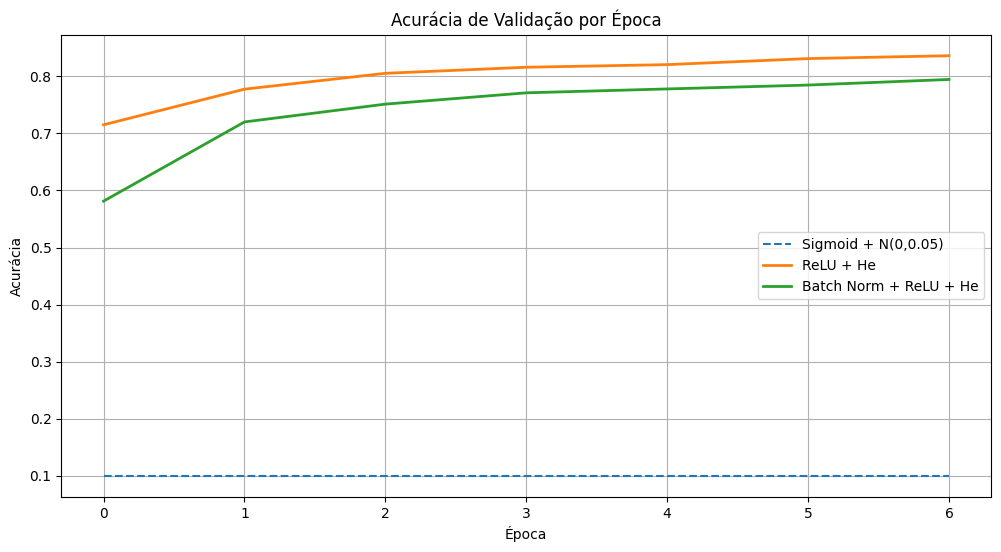

In [8]:
epochs = 7

print("--- Treinando Modelo Sigmoid (Base) ---")
history_sigmoid = model_sigmoid.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

print("--- Treinando Modelo ReLU + He (Moderno) ---")
history_relu = model_relu.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

print("--- Treinando Modelo com Batch Norm ---")
history_bn = model_bn.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(history_sigmoid.history['val_accuracy'], label='Sigmoid + N(0,0.05)', linestyle='--')
plt.plot(history_relu.history['val_accuracy'], label='ReLU + He', linewidth=2)
plt.plot(history_bn.history['val_accuracy'], label='Batch Norm + ReLU + He', linewidth=2)
plt.title('Acurácia de Validação por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()